In [68]:
import torch
import numpy as np 
import pandas as pd
from statistics import fmean
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from steamgrid import SteamGridDB
from steamgrid import StyleType, PlatformType, MimeType, ImageType
import requests
import os
import tqdm
import matplotlib.patches as patches

In [69]:
file_path = "/media/lars/F77E-7D07/"

In [70]:
lwi = pd.read_csv(file_path + "locations_with_images.csv")

In [71]:
lwi = lwi.drop("Unnamed: 0", axis=1)

In [72]:
lwi

,title,app_id,x,y,image_path,w,h
0,Prince of Persia: Warrior Within™,13500,-27.830263,-50.389065,thumbnails/13500.jpg,267,400
1,Monaco: What's Yours Is Mine,113020,-23.661060,-32.131130,thumbnails/113020.jpg,267,400
2,Escape Dead Island,226560,-21.555323,-15.315650,thumbnails/226560.jpg,267,400
3,METAL SLUG 3,250180,-21.135366,-32.897854,thumbnails/250180.jpg,267,400
4,Enclave,253980,-25.930891,-7.152575,thumbnails/253980.jpg,267,400
...,...,...,...,...,...,...,...
2528,Toodee and Topdee,1303950,8.808064,-12.508147,thumbnails/1303950.jpg,267,400
2529,Strategic Mind: Blitzkrieg,1200330,29.427100,51.273785,thumbnails/1200330.jpg,400,400
2530,Burnhouse Lane,1846460,-14.998375,-3.092490,thumbnails/1846460.jpg,267,400
2531,RiffTrax: The Game,1707870,6.705591,31.316670,thumbnails/1707870.jpg,267,400


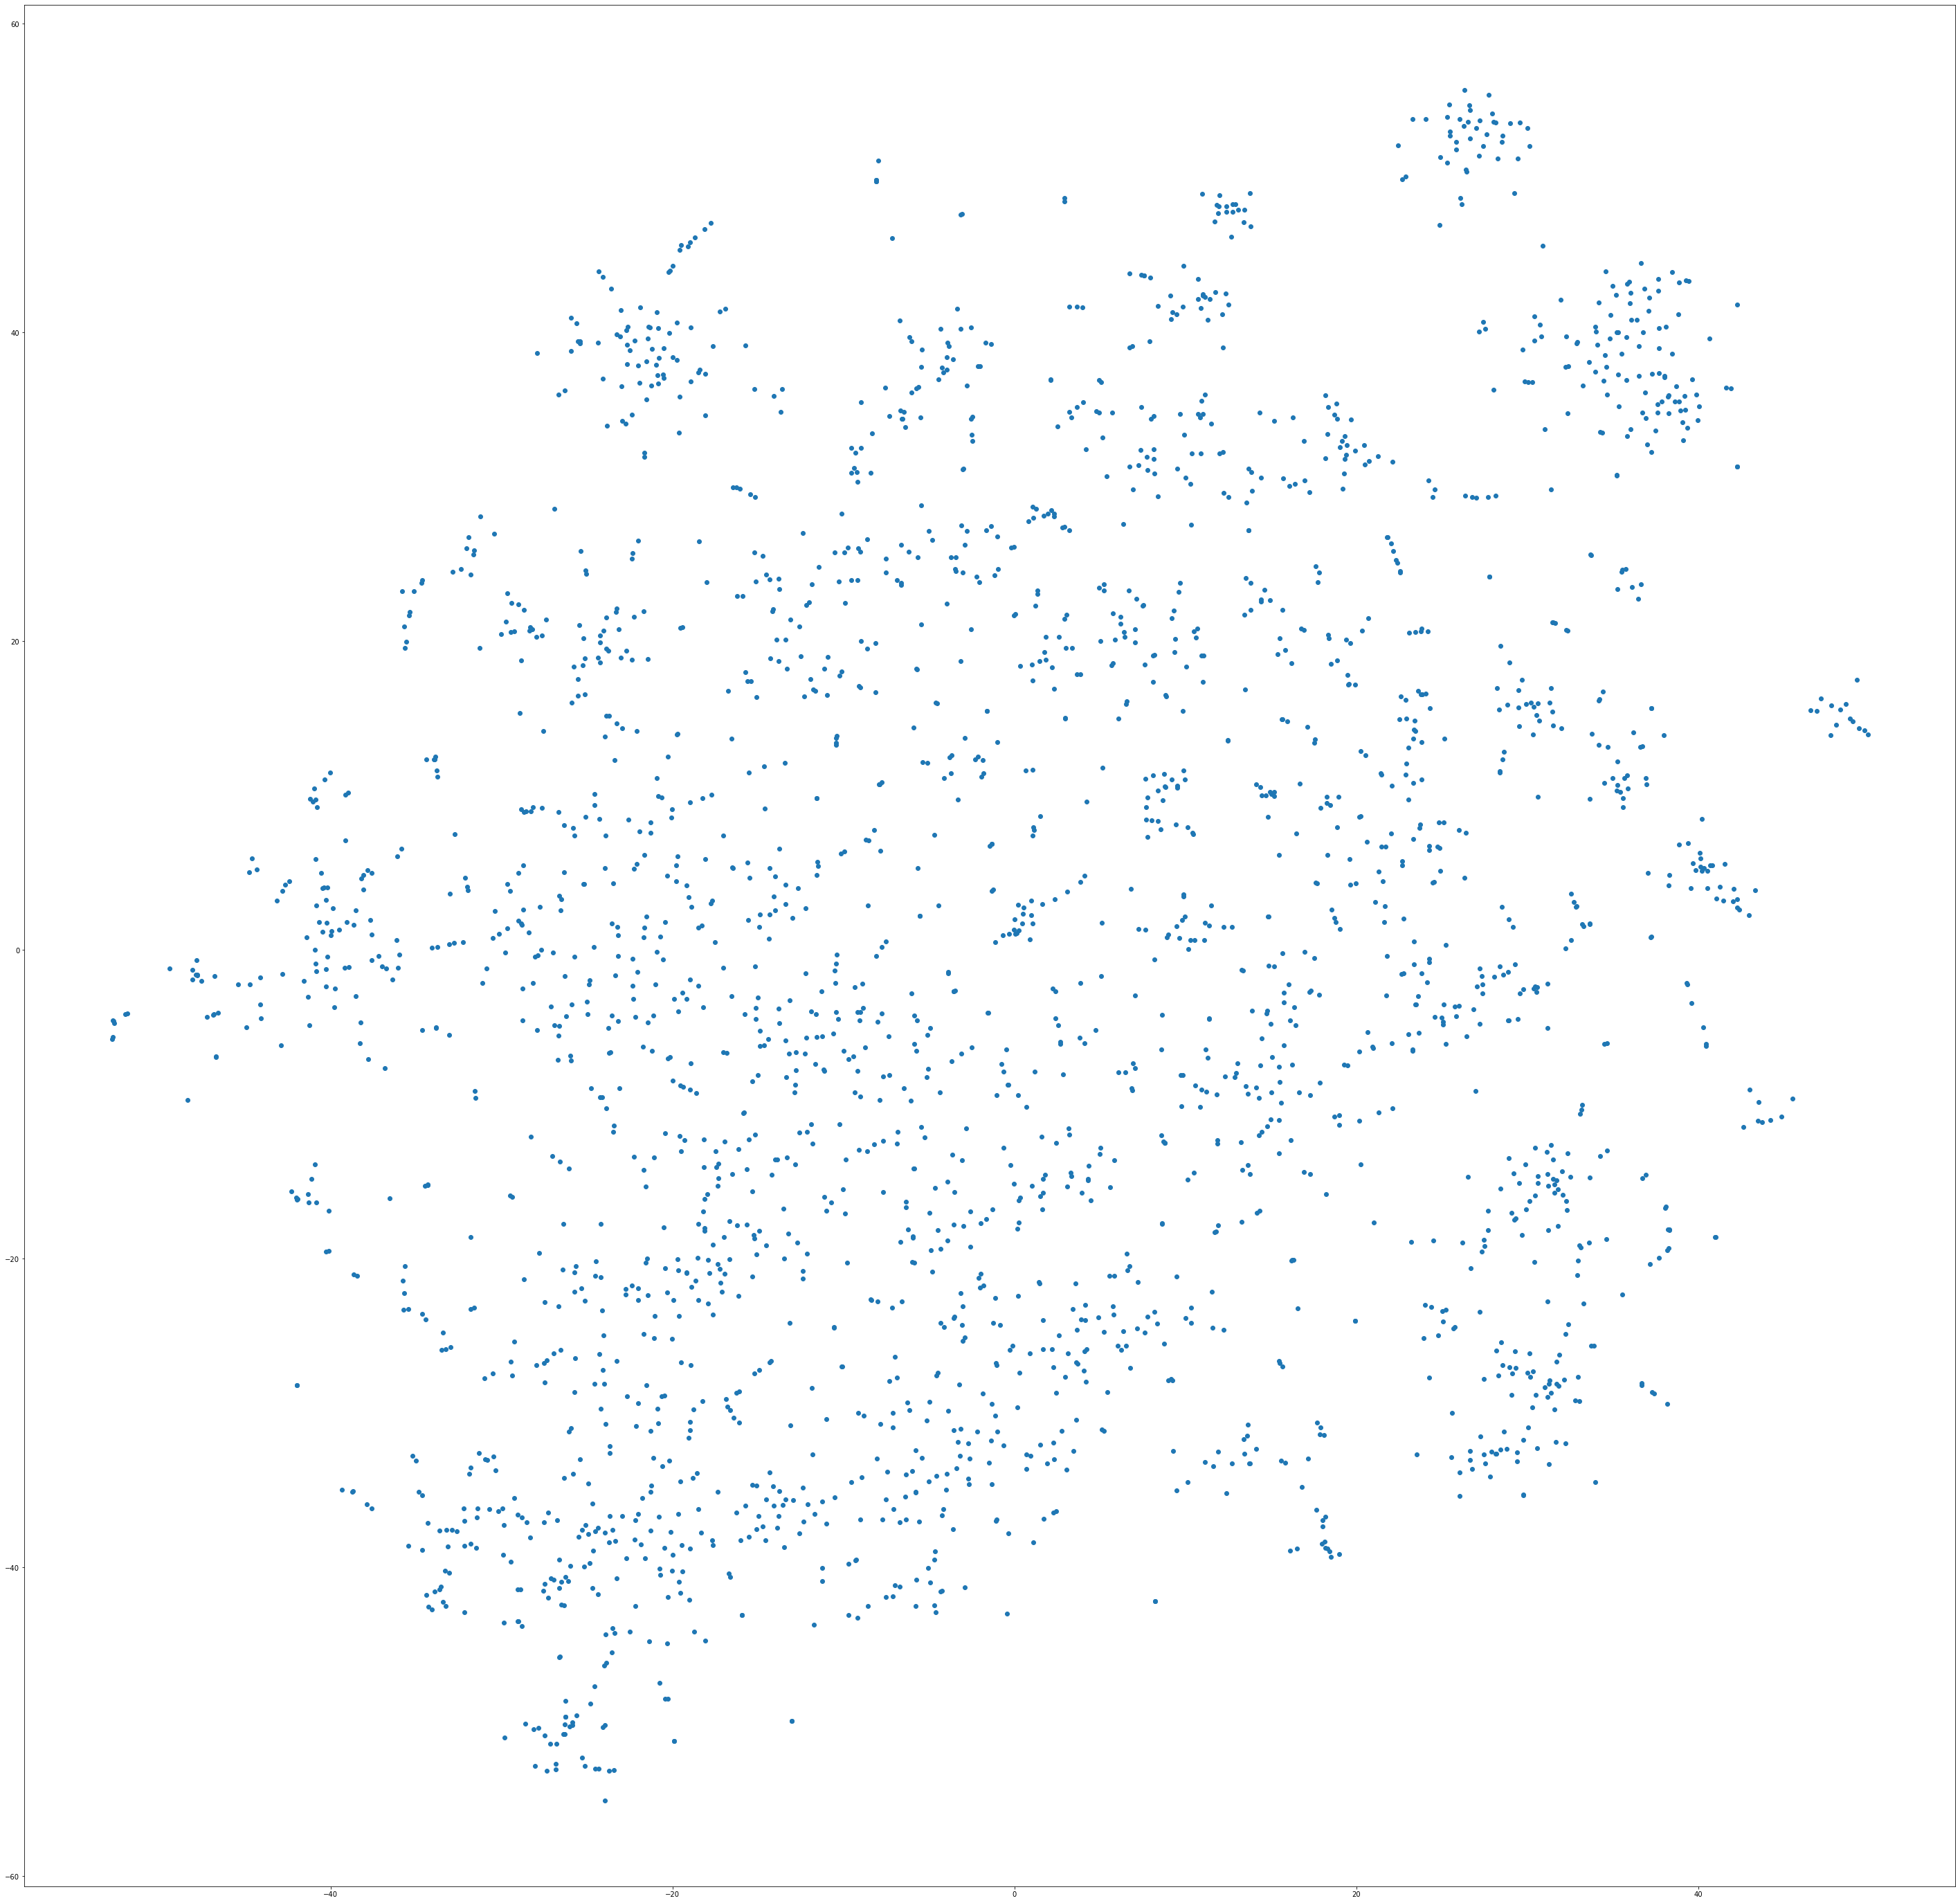

In [73]:
plt.figure(figsize=(50, 50))
plt.scatter(lwi["x"], lwi["y"])

In [74]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Parameters
pixel_length = 0.2 / 500
margin = 1
movement = 1 / 10
max_distance =  np.sqrt(2) * pixel_length * 500

def adjust_positions(lwi):
    """ Moves overlapping rectangles apart using KDTree """
    new_lwi = lwi.copy(deep=True)

    # Convert DataFrame to NumPy for speed
    coords = new_lwi[["x", "y"]].values
    widths = (new_lwi["w"] * pixel_length).values
    heights = (new_lwi["h"] * pixel_length).values

    # Build KDTree and find overlapping pairs
    tree = KDTree(coords)
    neighbor_pairs = tree.query_pairs(r=max_distance)  # Only check close neighbors

    changes = np.zeros_like(coords)  # Store movement updates

    count = 0
    for i, j in neighbor_pairs:
        x1, y1 = coords[i]
        x2, y2 = coords[j]
        w1, h1 = widths[i], heights[i]
        w2, h2 = widths[j], heights[j]

        dx, dy = x1 - x2, y1 - y2

        # ✅ Separate X and Y overlap checks
        overlap_x = abs(dx) < (w1 * margin / 2 + w2 * margin / 2)
        overlap_y = abs(dy) < (h1 * margin / 2 + h2 * margin / 2)

        if overlap_x or overlap_y:
            count += 1
            move_x = movement * np.sign(dx) * (w1 + w2) / 2 if overlap_x else 0
            move_y = movement * np.sign(dy) * (h1 + h2) / 2 if overlap_y else 0

            changes[i] += [move_x, move_y]
            changes[j] -= [move_x, move_y]

    # Apply updates in batch
    coords += changes
    new_lwi[["x", "y"]] = coords

    return new_lwi, count

# Run until no more overlaps
count = 1
while count > 0:
    new_lwi, count = adjust_positions(lwi)
    lwi = new_lwi  # Update DataFrame
    print(f"Remaining overlaps: {count}")


Remaining overlaps: 360
Remaining overlaps: 320
Remaining overlaps: 284
Remaining overlaps: 225
Remaining overlaps: 158
Remaining overlaps: 54
Remaining overlaps: 34
Remaining overlaps: 23
Remaining overlaps: 11
Remaining overlaps: 6
Remaining overlaps: 3
Remaining overlaps: 4
Remaining overlaps: 3
Remaining overlaps: 4
Remaining overlaps: 3
Remaining overlaps: 4
Remaining overlaps: 3
Remaining overlaps: 3
Remaining overlaps: 2
Remaining overlaps: 2
Remaining overlaps: 2
Remaining overlaps: 1
Remaining overlaps: 0


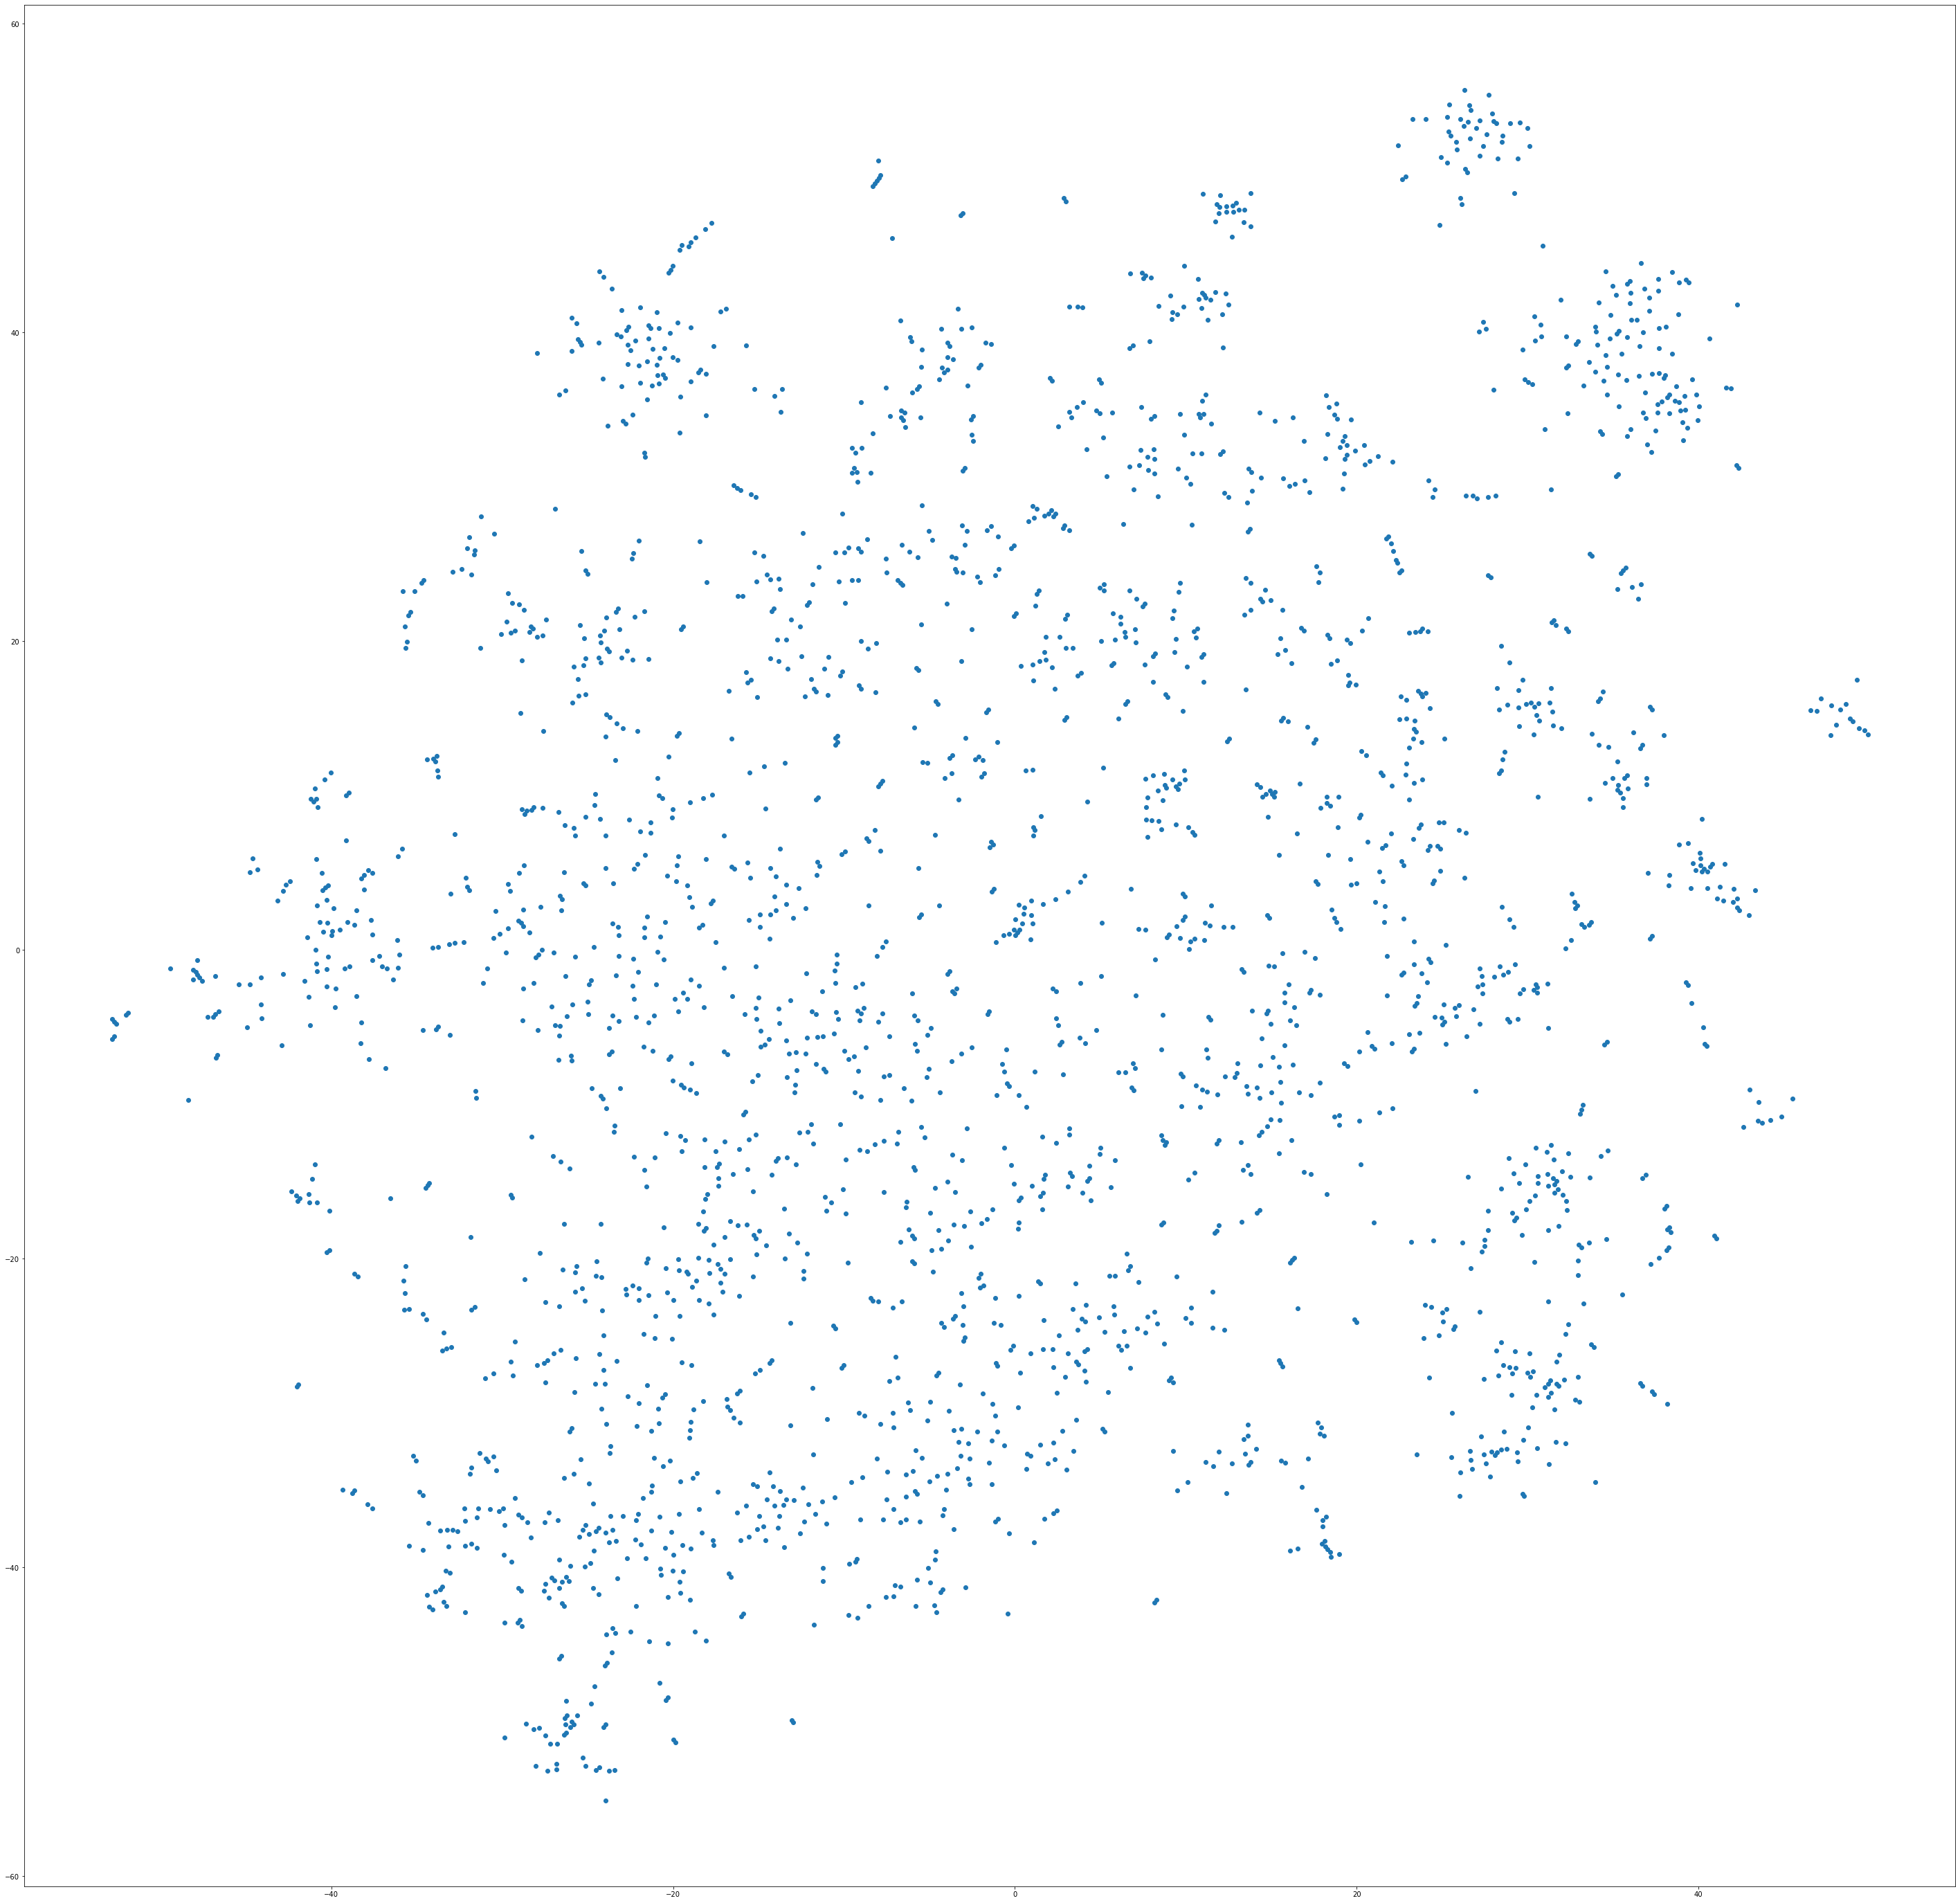

In [75]:
plt.figure(figsize=(50, 50))
plt.scatter(lwi["x"], lwi["y"])

In [76]:
lwi.to_csv("filtered_archive/final_locations.csv")